# Install Requirements

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
# !pip install git+https://github.com/ultralytics/ultralytics.git
!pip install kaggle opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.8/645.8 kB 10.1 MB/s eta 0:00:00


# Download Dataset

In [3]:
# # Download kaggle dataset
# import opendatasets as od

# od.download(
#     'https://www.kaggle.com/datasets/ujjwalchowdhury/yoga-pose-classification'
# )

In [4]:
# 다운로드 받은 파일 pose들의 directory(label값들) 확인
!ls /content/drive/MyDrive/miniproject/yoga-pose-classification/YogaPoses

Downdog  Goddess  Plank  Tree  Warrior2


# Yolov8 Pose

In [5]:
# import
import cv2
from PIL import Image, ImageFont, ImageDraw
from pydantic import BaseModel

import ultralytics

In [6]:
# pretrained model 불러오기
model = ultralytics.YOLO(model='yolov8x-pose.pt')

100%|██████████| 133M/133M [00:00<00:00, 246MB/s]


KeyboardInterrupt: ignored

In [ ]:
# 임의의 이미지를 가지고 keypoint, box의 좌표 추출
image = cv2.imread('/content/drive/MyDrive/miniproject/yoga-pose-classification/YogaPoses/Plank/00000006.jpg')
result = model.predict(image, save=True)[0]
result_keypoint = result.keypoints.xyn.cpu().numpy()[0]
result.boxes.xyxy

In [ ]:
# keypoint 값 확인 [17, 2]
result.keypoints[0]

In [ ]:
# 결과값
Image.fromarray(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))

# Generate Dataset
- Keypoint 추출

In [ ]:
# Keypoint 함수 선언 ex) 0 -> Nose
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()

In [ ]:
# import
import os
import glob

In [ ]:
# Dataset 경로 설정, labels 값 확인
dataset_root = '/content/drive/MyDrive/miniproject/yoga-pose-classification/YogaPoses'
pose_list = os.listdir(dataset_root)
pose_list

In [ ]:
# Keypoint 추출 함수 선언
def extract_keypoint(keypoint):
    # nose
    nose_x, nose_y = keypoint[get_keypoint.NOSE]
    # eye
    left_eye_x, left_eye_y = keypoint[get_keypoint.LEFT_EYE]
    right_eye_x, right_eye_y = keypoint[get_keypoint.RIGHT_EYE]
    # ear
    left_ear_x, left_ear_y = keypoint[get_keypoint.LEFT_EAR]
    right_ear_x, right_ear_y = keypoint[get_keypoint.RIGHT_EAR]
    # shoulder
    left_shoulder_x, left_shoulder_y = keypoint[get_keypoint.LEFT_SHOULDER]
    right_shoulder_x, right_shoulder_y = keypoint[get_keypoint.RIGHT_SHOULDER]
    # elbow
    left_elbow_x, left_elbow_y = keypoint[get_keypoint.LEFT_ELBOW]
    right_elbow_x, right_elbow_y = keypoint[get_keypoint.RIGHT_ELBOW]
    # wrist
    left_wrist_x, left_wrist_y = keypoint[get_keypoint.LEFT_WRIST]
    right_wrist_x, right_wrist_y = keypoint[get_keypoint.RIGHT_WRIST]
    # hip
    left_hip_x, left_hip_y = keypoint[get_keypoint.LEFT_HIP]
    right_hip_x, right_hip_y = keypoint[get_keypoint.RIGHT_HIP]
    # knee
    left_knee_x, left_knee_y = keypoint[get_keypoint.LEFT_KNEE]
    right_knee_x, right_knee_y = keypoint[get_keypoint.RIGHT_KNEE]
    # ankle
    left_ankle_x, left_ankle_y = keypoint[get_keypoint.LEFT_ANKLE]
    right_ankle_x, right_ankle_y = keypoint[get_keypoint.RIGHT_ANKLE]

    return [
        nose_x, nose_y,
        left_eye_x, left_eye_y,
        right_eye_x, right_eye_y,
        left_ear_x, left_ear_y,
        right_ear_x, right_ear_y,
        left_shoulder_x, left_shoulder_y,
        right_shoulder_x, right_shoulder_y,
        left_elbow_x, left_elbow_y,
        right_elbow_x, right_elbow_y,
        left_wrist_x, left_wrist_y,
        right_wrist_x, right_wrist_y,
        left_hip_x, left_hip_y,
        right_hip_x, right_hip_y,
        left_knee_x, left_knee_y,
        right_knee_x, right_knee_y,
        left_ankle_x, left_ankle_y,
        right_ankle_x, right_ankle_y
    ]

# Run image

In [ ]:
dataset_csv = []
for pose in pose_list:
    image_path_list = glob.glob(f'{dataset_root}/{pose}/*.jpg')
    for image_path in image_path_list:
        # get image_name
        image_name = image_path.split('/')[-1]
        # read numpy image
        image = cv2.imread(image_path)
        # get height width image
        height, width = image.shape[:2]

        # detect pose using yolov8-pose
        results = model.predict(image, save=False)[0]
        results_keypoint = results.keypoints.xyn.cpu().numpy()
        for result_keypoint in results_keypoint:
            if len(result_keypoint) == 17:
                keypoint_list = extract_keypoint(result_keypoint)

                # inset image_name, labe] in index 0,1
                keypoint_list.insert(0, image_name)
                keypoint_list.insert(1, pose)
                dataset_csv.append(keypoint_list)
        # break
    # break

In [ ]:
import csv
# write csv
header = [
    'image_name',
    'label',
    # nose
    'nose_x',
    'nose_y',
    # left eye
    'left_eye_x',
    'left_eye_y',
    # right eye
    'right_eye_x',
    'right_eye_y',
    # left ear
    'left_ear_x',
    'left_ear_y',
    # right ear
    'right_ear_x',
    'right_ear_y',
    # left shoulder
    'left_shoulder_x',
    'left_shoulder_y',
    # right sholder
    'right_shoulder_x',
    'right_shoulder_y',
    # left elbow
    'left_elbow_x',
    'left_elbow_y',
    # rigth elbow
    'right_elbow_x',
    'right_elbow_y',
    # left wrist
    'left_wrist_x',
    'left_wrist_y',
    # right wrist
    'right_wrist_x',
    'right_wrist_y',
    # left hip
    'left_hip_x',
    'left_hip_y',
    # right hip
    'right_hip_x',
    'right_hip_y',
    # left knee
    'left_knee_x',
    'left_knee_y',
    # right knee
    'right_knee_x',
    'right_knee_y',
    # left ankle
    'left_ankle_x',
    'left_ankle_y',
    # right ankle
    'right_ankle_x',
    'right_ankle_y'
]

with open('yoga_pose_keypoint.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(dataset_csv)

# Write Dataset

In [ ]:
# Dataframe 정보 확인, image_name col 삭제
import pandas as pd

df = pd.read_csv('yoga_pose_keypoint.csv')
df = df.drop('image_name', axis=1)
df.head()

In [ ]:
# import
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Read Dataset

In [ ]:
# 저장한 csv파일 읽기
df = pd.read_csv('/content/yoga_pose_keypoint.csv')
df.head()

In [ ]:
# DataFrame 정보
df.info()

In [ ]:
# 각 label의 개수 막대그래프
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# Train Test Split

In [ ]:
# encoder label
# label col의 문자(자세명)들을 숫자로 매핑
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

In [ ]:
# 클래스별 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

In [ ]:
# Get keypoint dataset
# 얼굴 부분 데이터 삭제(요가 자세 측정에는 얼굴부분의 데이터가 필요하지 않다.)
X = df.iloc[:,12:]
X

In [ ]:
# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=33)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

# Data Loader

In [ ]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [ ]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [ ]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model

In [ ]:
# 모델 정의
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [ ]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))

In [ ]:
len(class_weights)

# Loss & Optimizer

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
# 학습
num_epoch = 100

trigger_cnt = 0
patience=10
best_score = torch.inf
save_model_path = "/content/drive/MyDrive/miniproject/YoloV8-Pose-Keypoint-Classification/models/pose_classification.pth"

for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):

      # 결과 추출
      outputs = model(features)
      # loss 계산
      loss = criterion(outputs, labels)
      # 추론 결과 pred
      predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
      # 정답 개수
      correct = (predictions == labels).sum().item()
      # 정확도
      accuracy = correct / batch_size

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if loss < best_score: # 성능이 개선된 경우.
      #저장 로그 출력
      print(f"====> 모델저장:  {epoch+1} Epoch - 이전 loss: {best_score}, 현재 loss: {loss}")
      # best_score교체
      best_score = loss
      # 저장
      torch.save(model, save_model_path)
      # trigger_cnt 를 0으로 초기화
      trigger_cnt = 0
    else: # 성능개선이 안된경우.
      # trigger_cnt를 1 증가
      trigger_cnt += 1
      if patience == trigger_cnt: # patience 만큼 대기 ==> 조기 종료
        #로그
        print(f"=====> {epoch+1} Epoch에서 조기종료-{best_score}에서 개선 안됨")
        break


      loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
      loop.set_postfix(loss=loss.item(), acc=accuracy)

# Test Model

In [ ]:
# 분리한 테스트셋의 x값으로 pred값 추출
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features) # 모델에 X_test값을 넣어서 각 label에 대한 확률이 output이 된다.
    _, predictions = torch.max(outputs, 1) # output에서 가장 확률이 높은 label의 index가 pred값이 된다.
predictions

In [ ]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

In [ ]:
# confusion_matrix
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm,
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm

In [ ]:
# confusion matrix 그래프
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()

show_confusion_matrix(df_cm)

# Save model

In [ ]:
# 모델 저장
PATH_SAVE = '/content/drive/MyDrive/miniproject/YoloV8-Pose-Keypoint-Classification/models/pose_classification.pth'
torch.save(model.state_dict(), PATH_SAVE)

# Load Inference Model

In [ ]:
model_inference =  NeuralNet(
        X_train.shape[1],
        hidden_size,
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

In [ ]:
feature, label = test_dataset.__getitem__(51)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'
    )

In [ ]:
encoder.classes_

In [ ]:
%cd ..

# Test 추론

In [15]:
import os
os.getcwd()

'/content'

In [16]:
os.chdir("/content/drive/MyDrive/miniproject/YoloV8-Pose-Keypoint-Classification")
os.getcwd()

'/content/drive/MyDrive/miniproject/YoloV8-Pose-Keypoint-Classification'

In [21]:
# Import library
import cv2
import numpy as np
from PIL import Image
from src.detection_keypoint import DetectKeypoint
from src.classification_keypoint import KeypointClassification

In [22]:
detection_keypoint = DetectKeypoint()
classification_keypoint = KeypointClassification(
    '/content/drive/MyDrive/miniproject/YoloV8-Pose-Keypoint-Classification/models/pose_classification.pth'
)

In [ ]:
# wget 설치
!pip install wget
import wget

In [ ]:
# 외부 이미지 링크를 다운로드 받아 f_name으로 선언
f_name = wget.download("http://www.yogadestiny.com/uploads/7/4/9/7/7497330/2625707_orig.jpg")
f_name

# 사진 테스트

In [7]:
f_name = "/content/drive/MyDrive/miniproject/yoga-pose-classification/YogaPoses/Tree/00000032.jpg"
f_name

'/content/drive/MyDrive/miniproject/yoga-pose-classification/YogaPoses/Tree/00000032.jpg'

In [8]:
type(f_name)

str

In [23]:
# 실행, 키포인트 추출
image = cv2.imread(f_name)
results = detection_keypoint(image)


0: 640x640 1 person, 82.4ms
Speed: 19.6ms preprocess, 82.4ms inference, 48.8ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
type(image)

numpy.ndarray

In [11]:
type(results)

NameError: ignored

In [24]:
# 키포인트 값
results_keypoints = results.keypoints

In [25]:
results_keypoints

ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9876, 0.9450, 0.9725, 0.6884, 0.8523, 0.9573, 0.9970, 0.8271, 0.9900, 0.8403, 0.9733, 0.9974, 0.9991, 0.9965, 0.9978, 0.9701, 0.9871]], device='cuda:0')
data: tensor([[[143.6249,  63.1356,   0.9876],
         [146.5891,  60.0698,   0.9450],
         [140.5023,  60.4834,   0.9725],
         [150.1965,  62.2568,   0.6884],
         [136.6274,  63.2394,   0.8523],
         [160.5370,  71.6806,   0.9573],
         [129.2820,  71.3653,   0.9970],
         [156.8009,  56.0111,   0.8271],
         [127.1438,  53.9251,   0.9900],
         [148.8099,  29.1170,   0.8403],
         [136.6532,  30.9265,   0.9733],
         [148.8673, 131.5363,   0.9974],
         [125.8111, 125.8802,   0.9991],
         [139.9027, 163.0797,   0.9965],
         [104.7800, 143.2883,   0.9978],
         [133.7281, 206.9102,   0.9701],
         [125.7657, 146.8276,   0.9871]]], device='cuda:0')
has_visible: True
orig_shape: (240, 240)
shape

In [26]:
# 키포인트를 바탕으로 자세 추론
results_keypoint = detection_keypoint.get_xy_keypoint(results)

input_classification = results_keypoint[10:]  # 자세를 추론하는데 있어 얼굴부분은 필요하지 않기 때문에 10번 index(left_shoulder)부터 추론에 활용
results_classification = classification_keypoint(input_classification) # 키포인트 데이터를 가지고 자세 분류
results_classification

'Tree'

Keypoint classification : Tree


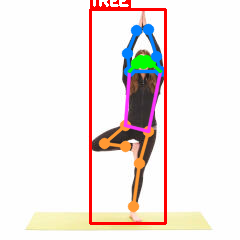

In [27]:
## Visualise Keypoint
height, width = image.shape[:2]
image_draw = results.plot(boxes=False)
import torch
# ...
# 이전 코드
# x_min, y_min, x_max, y_max = results.boxes.xyxy[0].numpy()
# 수정된 코드
if results.boxes is not None and len(results.boxes) > 0:
    # CUDA 텐서를 CPU로 복사하고 나서 NumPy로 변환
    x_min, y_min, x_max, y_max = results.boxes.xyxy[0].cpu().numpy()
    # 나머지 코드 실행
else:
    print("Bounding box 정보가 없습니다.")
image_draw = cv2.rectangle(
                image_draw,
                (int(x_min), int(y_min)),(int(x_max), int(y_max)),
                (0,0,255), 2
            )
(w, h), _ = cv2.getTextSize(
        results_classification.upper(),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
    )
image_draw = cv2.rectangle(
                image_draw,
                (int(x_min), int(y_min)-20),(int(x_min)+w, int(y_min)),
                (0,0,255), -1
            )
cv2.putText(image_draw,
            f'{results_classification.upper()}',
            (int(x_min), int(y_min)-4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (255, 255, 255),
            thickness=2
        )


print(f'Keypoint classification : {results_classification}')
Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

# KeyPoint 추출 및 각도 조절

Keypoint classification : Tree


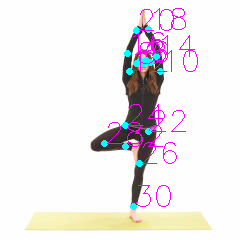

In [28]:
## Visualise Keypoint
height, width = image.shape[:2]

image_draw = image.copy()
for idx in range(0, len(results_keypoint), 2):
    x, y = results_keypoint[idx], results_keypoint[idx+1]
    if x == 0 or x == 1: continue
    if y == 0 or y == 1: continue
    x, y = int(x*width), int(y*height)
    # visualize point
    image_draw = cv2.circle(image_draw, (x,y), 2, (255,255,0), 2)
    image_draw = cv2.putText(image_draw, str(idx), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1,  (255,0,255),1)

print(f'Keypoint classification : {results_classification}')
Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

In [29]:
results.keypoints

ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9876, 0.9450, 0.9725, 0.6884, 0.8523, 0.9573, 0.9970, 0.8271, 0.9900, 0.8403, 0.9733, 0.9974, 0.9991, 0.9965, 0.9978, 0.9701, 0.9871]], device='cuda:0')
data: tensor([[[143.6249,  63.1356,   0.9876],
         [146.5891,  60.0698,   0.9450],
         [140.5023,  60.4834,   0.9725],
         [150.1965,  62.2568,   0.6884],
         [136.6274,  63.2394,   0.8523],
         [160.5370,  71.6806,   0.9573],
         [129.2820,  71.3653,   0.9970],
         [156.8009,  56.0111,   0.8271],
         [127.1438,  53.9251,   0.9900],
         [148.8099,  29.1170,   0.8403],
         [136.6532,  30.9265,   0.9733],
         [148.8673, 131.5363,   0.9974],
         [125.8111, 125.8802,   0.9991],
         [139.9027, 163.0797,   0.9965],
         [104.7800, 143.2883,   0.9978],
         [133.7281, 206.9102,   0.9701],
         [125.7657, 146.8276,   0.9871]]], device='cuda:0')
has_visible: True
orig_shape: (240, 240)
shape

# 한글 텍스트 표현

In [30]:
# 한글 출력에 필요한 폰트 설치
!sudo apt-get install fonts-nanum*
!sudo fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 10 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0

In [31]:
from src.calc_degree import calc_degree
# 자세에 따른 각도 계산 및 피드백 출력 함수
# labels -> ['Warrior2', 'Plank', 'Goddess', 'Tree', 'Downdog']

# posename = results_classification
# keypoints = results.keypoints
def TextExtract(posename, keypoints):

  # Warrior2 자세일 경우 -> 수정 완료
  if posename == 'Warrior2':
    # 세 점 사이 각도 구하는 함수. 상체 팔 쭉 피도록 keypoint index: 오른쪽 손목-10, 왼쪽 어깨-5, 왼쪽 손목-9
    degree1 = calc_degree(keypoints.xy[0, 10].cpu().numpy(), keypoints.xy[0, 5].cpu().numpy(), keypoints.xy[0, 9].cpu().numpy())

    # 왼쪽다리 keypoint index: 왼쪽 엉덩이-11, 왼쪽 무릎:13, 왼쪽 발목-15
    degree3 = calc_degree(keypoints.xy[0, 11].cpu().numpy(), keypoints.xy[0, 13].cpu().numpy(), keypoints.xy[0, 15].cpu().numpy())

    # 세 점 사이 각도 구하는 함수. 오른쪽 다리 keypoint index: 오른쪽 엉덩이-12, 오른쪽 무릎:14, 오른쪽 발목-16
    degree4 = calc_degree(keypoints.xy[0, 12].cpu().numpy(), keypoints.xy[0, 14].cpu().numpy(), keypoints.xy[0, 16].cpu().numpy())

    feedback_text = ""
    # text = f"{degree1}\n{degree3}\n{degree4}\n"

    # 상체 피드백
    if 160 <= degree1 <= 200:
      feedback_text += "올바른 자세입니다.(상체)\n"
    else:
      feedback_text += "팔을 수평으로 맞춰주세요\n"

    # 다리 피드백
    if degree3 > degree4:
      if degree4 > 120:
        feedback_text += "오른쪽 다리의 각도를 좁혀주세요."
      elif degree4 < 50:
        feedback_text += "오른쪽 다리의 각도를 넓혀주세요."
      else:
        feedback_text += "올바른 자세입니다.(하체)"
    else:
      if degree3 > 120:
        feedback_text += "왼쪽 다리의 각도를 좁혀주세요."
      elif degree3 < 50:
        feedback_text += "왼쪽 다리의 각도를 넓혀주세요."
      else:
        feedback_text += "올바른 자세입니다.(하체)"

    return feedback_text

  # Plank 자세일 경우 -> 수정 완료
  elif posename == 'Plank':
    # 왼쪽 추출 keypoints 중 하나라도 0이 있다면, 오른쪽 keypoint 추출 조건식
    if keypoints.xy[0, 5].cpu() == [0, 0] or keypoints.xy[0, 11].cpu() == [0, 0] or keypoints.xy[0, 15].cpu() == [0, 0]:
      # keypoint index: 오른쪽 어깨-6, 오른쪽 골반:12, 오른쪽 발목-16
      degree = calc_degree(keypoints.xy[0, 6].cpu().numpy(), keypoints.xy[0, 12].cpu().numpy(), keypoints.xy[0, 16].cpu().numpy())
    else:
      # 세 점 사이 각도 구하는 함수. keypoint index: 왼쪽 어깨-5, 왼쪽 골반:11, 왼쪽 발목-15
      degree = calc_degree(keypoints.xy[0, 5].cpu().numpy(), keypoints.xy[0, 11].cpu().numpy(), keypoints.xy[0, 15].cpu().numpy())

    # text = f"{degree}\n" # 각도 테스트

    feedback_text = ""

    if 130 <= degree <= 200:
      feedback_text += f"올바른 자세입니다."
    else:
      feedback_text += "몸을 수평하게 만들어 주세요."

    return feedback_text

  # Goddess 자세일 경우 -> 수정 완료
  elif posename == 'Goddess':
    # Goddess자세는 허리 위로 (팔부분)이 너무 다양하여 다리의 각도만 사용해서 피드백하기로 결정.

    # 왼쪽다리 keypoint index: 왼쪽 엉덩이-11, 왼쪽 무릎:13, 왼쪽 발목-15
    degree1 = calc_degree(keypoints.xy[0, 11].cpu().numpy(), keypoints.xy[0, 13].cpu().numpy(), keypoints.xy[0, 15].cpu().numpy())

    # 오른쪽다리 keypoint index: 오른쪽 엉덩이-12, 오른쪽 무릎:14, 오른쪽 발목-16
    degree2 = calc_degree(keypoints.xy[0, 12].cpu().numpy(), keypoints.xy[0, 14].cpu().numpy(), keypoints.xy[0, 16].cpu().numpy())

    degree_list = [degree1, degree2]
    feedback_text = ""

    if 70 <= degree1 <= 130 and 70 <= degree2 <= 130:
      feedback_text += "올바른 자세 입니다."
    else:
      for i in degree_list:
        if i == degree1:
          if i < 70:
            feedback_text += "왼쪽다리를 더 펴주세요\n"
          elif i > 130:
            feedback_text += "왼쪽다리를 굽혀주세요\n"
        else:
          if i < 70:
            feedback_text += "오른다리를 더 펴주세요\n"
          elif i > 130:
            feedback_text += "오른다리를 굽혀주세요\n"

    return feedback_text

  # Tree 자세일 경우 -> 수정완료
  elif posename == 'Tree':

    # 왼쪽다리각도 : 왼쪽 골반:11, 왼쪽 무릎-13, 왼쪽 발목-15
    degree1 = calc_degree(keypoints.xy[0, 11].cpu().numpy(), keypoints.xy[0, 13].cpu().numpy(), keypoints.xy[0, 15].cpu().numpy())
    # 오른쪽다리각도 : 오른쪽 골반-12, 오른쪽 무릎:14, 오른쪽 발목-16
    degree2 = calc_degree(keypoints.xy[0, 12].cpu().numpy(), keypoints.xy[0, 14].cpu().numpy(), keypoints.xy[0, 16].cpu().numpy())

    feedback_text = "" # 피드백 텍스트

    if degree1 > degree2: # 오른발 올림
      if degree2 > 100:
        feedback_text += "오른발을 더 올려주세요.\n"
      else:
        feedback_text += "올바른 자세입니다.\n"
    else: # 왼발 올림
      if degree1 > 100:
        feedback_text += "왼발을 더 올려주세요.\n"
      else:
        feedback_text += "올바른 자세입니다.\n"

    return feedback_text

  # Downdog 자세일 경우 -> 수정 완료
  elif posename == 'Downdog':
    # 왼쪽 추출 keypoints 중 하나라도 0이 있다면, 오른쪽 keypoint 추출 조건식

    if keypoints.xy[0, 5].cpu() == [0, 0] or keypoints.xy[0, 9].cpu() == [0, 0] or keypoints.xy[0, 11].cpu() == [0, 0] or keypoints.xy[0, 15].cpu() == [0, 0]:
      # keypoint index: 오른쪽 어깨-6, 오른쪽 골반-12, 오른쪽 발목-16
      degree1 = calc_degree(keypoints.xy[0, 6].cpu().numpy(), keypoints.xy[0, 12].cpu().numpy(), keypoints.xy[0, 16].cpu().numpy())
      # keypoint index: 오른쪽 손목-10, 오른쪽 어깨-6, 오른쪽 골반-12
      degree2 = calc_degree(keypoints.xy[0, 10].cpu().numpy(), keypoints.xy[0, 6].cpu().numpy(), keypoints.xy[0, 12].cpu().numpy())
    else:
      # keypoint index: 왼쪽 어깨-5, 왼쪽 골반-11, 왼쪽 발목-15
      degree1 = calc_degree(keypoints.xy[0, 5].cpu().numpy(), keypoints.xy[0, 11].cpu().numpy(), keypoints.xy[0, 15].cpu().numpy())
      # keypoint index: 왼쪽 손목-9, 왼쪽 어깨-5, 왼쪽 골반-11
      degree2 = calc_degree(keypoints.xy[0, 9].cpu().numpy(), keypoints.xy[0, 5].cpu().numpy(), keypoints.xy[0, 11].cpu().numpy())

    degree_list = [degree1, degree2]
    feedback_text = ""

    # Text = f"{degree1}\n {degree2}\n"
    if 70 <= degree1 <= 120 and 150 <= degree2 <= 200:
      feedback_text += "올바른 자세입니다."
    else:
      for i in degree_list:
        if i == degree1:
            if degree1 < 70:
                feedback_text += "손과 발 사이를 넓혀주세요.\n"
            elif degree1 > 120:
                feedback_text += "손과 발 사이를 좁혀주세요.\n"
        else:
            if degree2 < 150 or degree2 > 200:
                feedback_text += "상체를 수평이 되도록 만들어주세요."

    return feedback_text

In [32]:
# 폰트설정(폰트객체 생성)
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'
font = ImageFont.truetype(font_path, 20) # 폰트파일경로, 폰트크기

Keypoint classification : Tree


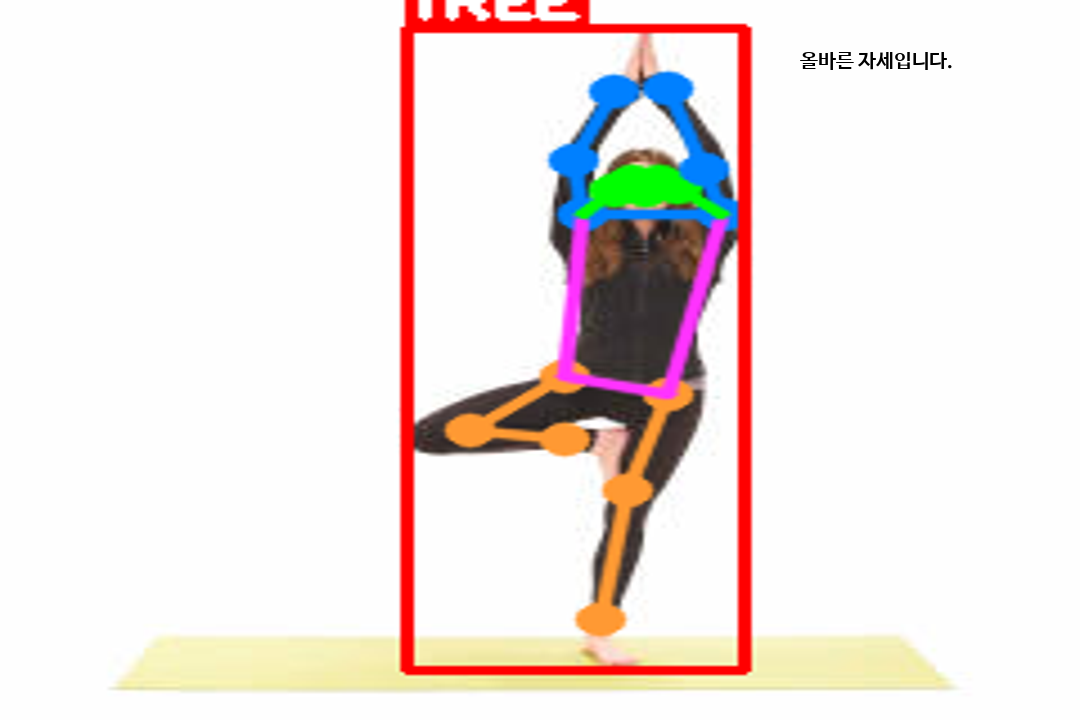

In [33]:
## Visualise Keypoint

height, width = image.shape[:2]
image_draw = results.plot(boxes=False)
import torch

# ...
# 이전 코드
# x_min, y_min, x_max, y_max = results.boxes.xyxy[0].numpy()
# 수정된 코드
if results.boxes is not None and len(results.boxes) > 0:
    # CUDA 텐서를 CPU로 복사하고 나서 NumPy로 변환
    x_min, y_min, x_max, y_max = results.boxes.xyxy[0].cpu().numpy()
    # 나머지 코드 실행
else:
    print("Bounding box 정보가 없습니다.")

image_draw = cv2.rectangle(
                image_draw,
                (int(x_min), int(y_min)),(int(x_max), int(y_max)),
                (0,0,255), 2
            )
(w, h), _ = cv2.getTextSize(
        results_classification.upper(),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
    )
image_draw = cv2.rectangle(
                image_draw,
                (int(x_min), int(y_min)-20),(int(x_min)+w, int(y_min)),
                (0,0,255), -1
            )
cv2.putText(image_draw,
            f'{results_classification.upper()}',
            (int(x_min), int(y_min)-4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (255, 255, 255),
            thickness=2
        )
# 텍스트 설정
text = TextExtract(results_classification, results_keypoints) # 자세 및 각도 파라미터를 함수로 받아 출력할 텍스트를 return 받는다.
img_pil = Image.fromarray(image_draw)
img_pil = img_pil.resize((1080,720))
draw = ImageDraw.Draw(img_pil)
# (좌표, 좌표): 좌하단좌표 값
draw.text((800,50), text, (0, 0, 0), font=font)
# img_pil = img_pil.resize((1000,640))
image_draw = np.array(img_pil)

print(f'Keypoint classification : {results_classification}')
Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))